## 2.5 Sarsaで迷路を攻略

In [1]:
# 使用するパッケージの宣言
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


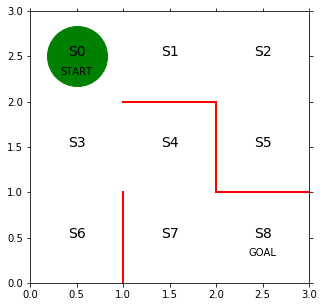

In [2]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)


In [3]:
# 初期の方策を決定するパラメータtheta_0を設定

# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])


In [4]:
# 方策パラメータtheta_0をランダム方策piに変換する関数の定義


def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''

    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)


In [5]:
# 初期の行動価値関数Qを設定

[a, b] = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0
# * theta0をすることで要素ごとに掛け算をし、Qの壁方向の値がnanになる


In [6]:
# ε-greedy法を実装


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next


In [7]:
# Sarsaによる行動価値関数Qの更新


def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):

    if s_next == 8:  # ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

    return Q


In [8]:
# Sarsaで迷路を解く関数の定義、状態と行動の履歴および更新したQを出力


def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初期の行動
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        a = a_next  # 行動更新

        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        # 報酬を与え,　次の行動を求めます
        if s_next == 8:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求めます。

        # 価値関数を更新
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)

        # 終了判定
        if s_next == 8:  # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]


In [9]:
# Sarsaで迷路を解く

eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード:" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Sarsaで迷路を解き、移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
    print(np.sum(np.abs(new_v - v)))  # 状態価値の変化を出力
    v = new_v

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode = episode + 1
    if episode > 100:
        break


エピソード:1
1.740397889068286
迷路を解くのにかかったステップ数は340です
エピソード:2
0.13503458373686233
迷路を解くのにかかったステップ数は22です
エピソード:3
0.09246907428716789
迷路を解くのにかかったステップ数は16です
エピソード:4
0.5063317503848415
迷路を解くのにかかったステップ数は196です
エピソード:5
0.05687631793450576
迷路を解くのにかかったステップ数は6です
エピソード:6
0.04893807621655272
迷路を解くのにかかったステップ数は4です
エピソード:7
0.04834899787371577
迷路を解くのにかかったステップ数は4です
エピソード:8
0.04761908880205956
迷路を解くのにかかったステップ数は4です
エピソード:9
0.04677645290000576
迷路を解くのにかかったステップ数は4です
エピソード:10
0.045843864856086325
迷路を解くのにかかったステップ数は4です
エピソード:11
0.04483983782974399
迷路を解くのにかかったステップ数は4です
エピソード:12
0.043779485479883695
迷路を解くのにかかったステップ数は4です
エピソード:13
0.042675215047680126
迷路を解くのにかかったステップ数は4です
エピソード:14
0.04153728211886826
迷路を解くのにかかったステップ数は4です
エピソード:15
0.040374232555446865
迷路を解くのにかかったステップ数は4です
エピソード:16
0.03919325275759161
迷路を解くのにかかったステップ数は4です
エピソード:17
0.038000445773695934
迷路を解くのにかかったステップ数は4です
エピソード:18
0.03680104771690318
迷路を解くのにかかったステップ数は4です
エピソード:19
0.03559959638219756
迷路を解くのにかかったステップ数は4です
エピソード:20
0.034400061813603666
迷路を解くのにかかったステップ数は4です
